In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

%matplotlib inline

# Economy: Demand & Supply

<img src="https://thumbs.dreamstime.com/b/supply-demand-26790633.jpg" width='500px' height='300px'>

In [2]:
data = pd.read_csv('v1.csv')
P, D, S = data['Price'].values, data['Demand'].values, data['Supply'].values
data

,Price,Demand,Supply
0,0.10,100,10
1,0.30,69,25
2,0.45,58,39
3,0.70,40,52
4,0.80,35,60
5,1.05,20,84
6,1.20,18,91
7,1.25,17,95
8,1.31,19,97
9,1.40,21,100


In [3]:
def plot(*args, x='Quantity', y='Price', **kw):
    plt.figure(figsize=(15, 10))
    plt.plot(*args)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(kw['legend'])
    plt.title(kw['title'])
    plt.show()

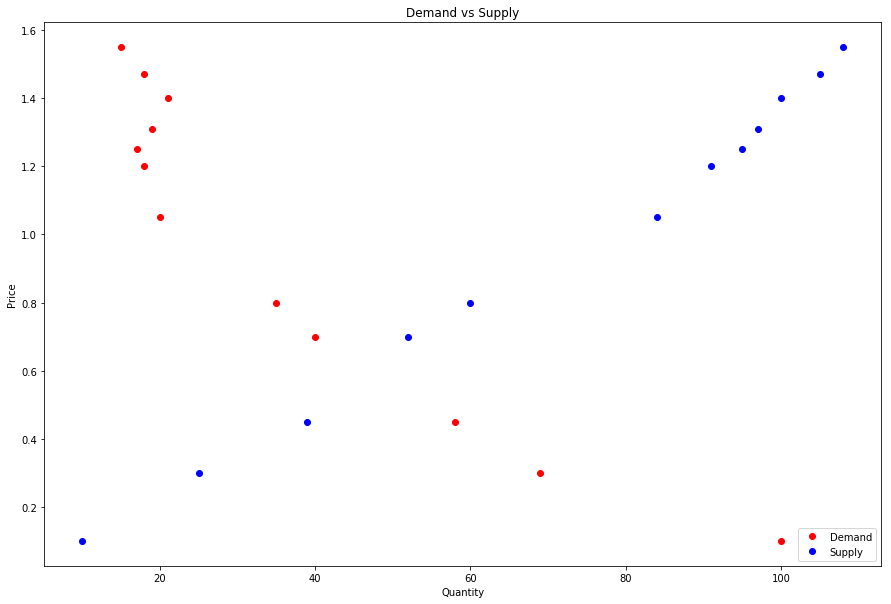

In [4]:
plot(D, P, 'ro', S, P, 'bo', legend=['Demand', 'Supply'], title='Demand vs Supply')

## Approximation

In [5]:
def compare(x, y, fs, label, title):
    plt.figure(figsize=(15, 10))
    scores, cs = [], []
    for i, f in enumerate(fs):
        c, _ = curve_fit(f, x, y)
        fy = f(x, *c)
        plt.plot(fy, x, '-', label=f.__name__)
        scores.append(np.sum(y - fy)**2)
        cs.append(c)
    plt.plot(y, x, 'o', label=label)
    plt.xlabel('Quantity'); plt.ylabel('Price')
    plt.legend(); plt.title(title); plt.show()
    return fs[np.argmin(scores)], cs[np.argmin(scores)]

We'll try to approximate our demand function with
$$Q_d(P) = \frac{a}{bP + c}$$

$$Q_d(P) = \frac{a}{e^{bP} + c}$$

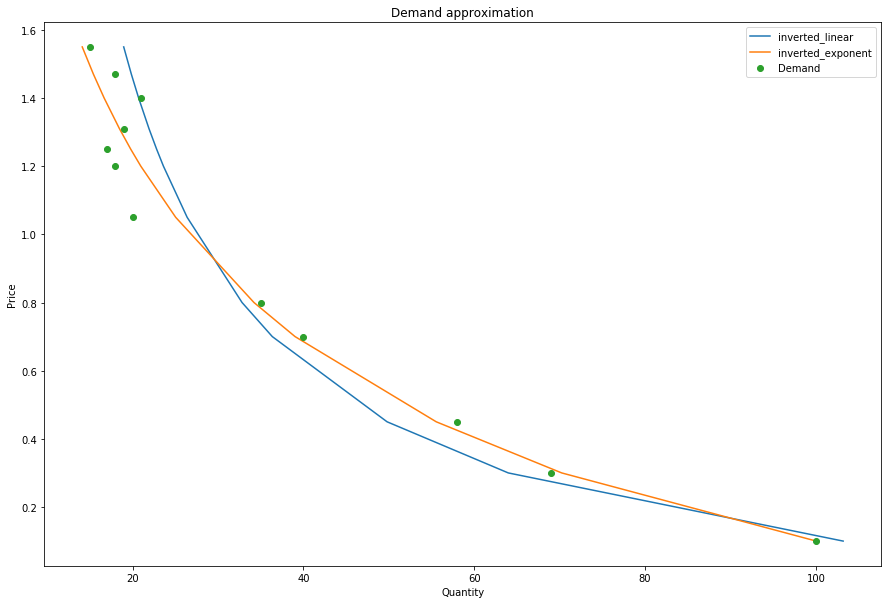

'Demand is better to approximate with inverted_exponent function'

In [6]:
def inverted_linear(x, a, b, c):   return a / (b*x + c)
def inverted_exponent(x, a, b, c): return a / (np.exp(b*x) + c)

d_f, d_c = compare(P, D, [inverted_linear, inverted_exponent], label='Demand', title='Demand approximation')
'Demand is better to approximate with {} function'.format(d_f.__name__)

Now let's approximate our supply function with
$$Q_s(P) = e^{aP} + b$$

$$Q_s(P) = a\log{P} + b$$

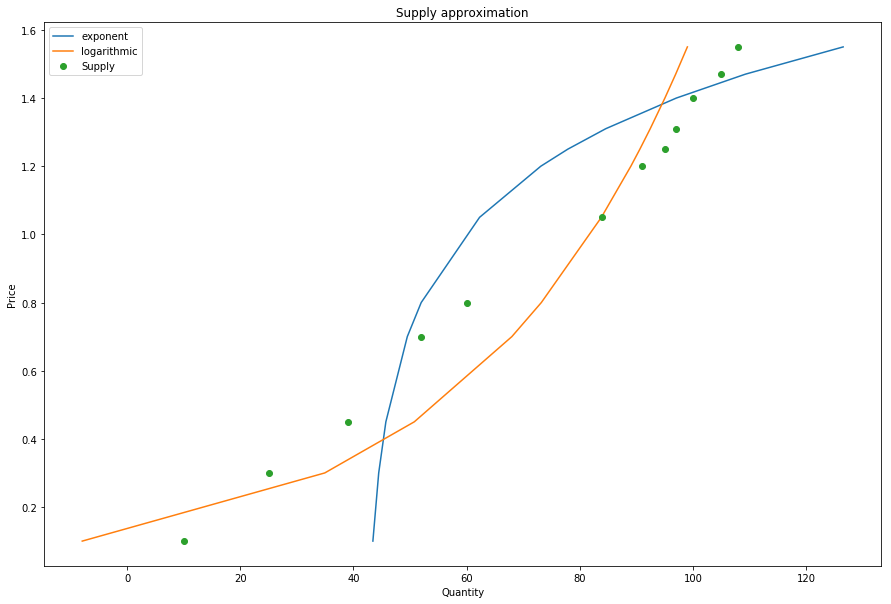

'Supply is better to approximate with logarithmic function'

In [7]:
def exponent(x, a, b):    return np.exp(a*x) + b
def logarithmic(x, a, b): return a*np.log(x) + b

s_f, s_c = compare(P, S, [exponent, logarithmic], label='Supply', title='Supply approximation')
'Supply is better to approximate with {} function'.format(s_f.__name__)

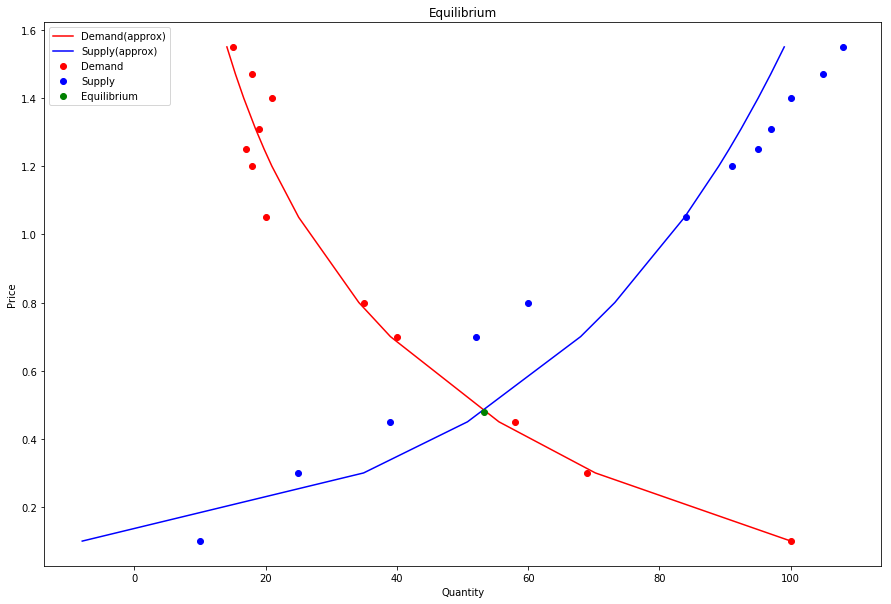

'Equilibrium is (53.21, 0.48)'

In [8]:
def diff(x): return abs(d_f(x, *d_c) - s_f(x, *s_c))

bounds = (P.min(), P.max())
e_p = minimize(diff, 1, bounds=[bounds]).x[0]
e_q = d_f(e_p, *d_c)
plot(d_f(P, *d_c), P, 'r-', s_f(P, *s_c), P, 'b-', D, P, 'ro', S, P, 'bo', e_q, e_p, 'go',
     legend=['Demand(approx)', 'Supply(approx)', 'Demand', 'Supply', 'Equilibrium'], title='Equilibrium')
'Equilibrium is ({0:.2f}, {1:.2f})'.format(e_q, e_p)

## Elasticity

By definition
$$E = \frac{dQ}{dP} \cdot \frac{P}{Q}$$

For demand we have
$$Q_d = \frac{a}{e^{bP}+c}$$

$$E_d = \frac{dQ_d}{dP} \cdot \frac{P}{Q_d} = -\frac{abe^{bP}}{(e^{bP}+c)^2} \cdot \frac{P(e^{bP}+c)}{a} =
-\frac{bPe^{bP}}{e^{bP}+c}$$

And for supply
$$Q_s = l\log{P}+m$$

$$E_s = \frac{dQ_s}{dP} \cdot \frac{P}{Q_s} = \frac{l}{P} \cdot \frac{P}{l\log{P}+m} =
\frac{l}{l\log{P}+m}$$

In [9]:
d_c, s_c

(array([ 55.41340061,   0.96686209,  -0.54762499]),
 array([ 39.0227966 ,  81.92435634]))

Provided that $a = 55.4, b = 0.97, c = -0.55, l = 39.02, m = 81.92$ we have

$$E_d = -\frac{0.97 \cdot Pe^{0.97 P}}{e^{0.97 P}-0.55}$$

$$E_s = \frac{39.02}{39.02\log{P}+81.92}$$

Let's calculate elasticity at the equilibrium

In [10]:
def elasticity_d(p): return -d_c[1]*p*np.exp(d_c[1]*p) / (np.exp(d_c[1]*p) - d_c[2])
def elasticity_s(p): return s_c[0] / (s_c[0]*np.log(p) + s_c[1])

print('Demand elasticity: {0:.2f}'.format(elasticity_d(e_p)))
print('Supply elasticity: {0:.2f}'.format(elasticity_s(e_p)))

Demand elasticity: -0.34
Supply elasticity: 0.73


Because $|E_d(e_p)| < |E_s(e_p)|$ we can say that equilibrium is **not stable**.

## Arc elasticity

$$E_{arc} = \frac{Q_n - Q_1}{P_n - P_1} \frac{\frac{\sum_{i=1}^n P_i }{n}}{\frac{\sum_{i=1}^n Q_i }{n}} = \frac{Q_n - Q_1}{P_n - P_1} \frac{\sum_{i=1}^n P_i }{\sum_{i=1}^n Q_i }$$

In [11]:
def arc_elasticity(P, Q): return (Q[-1] - Q[0]) / (P[-1] - P[0]) * np.sum(P) / np.sum(Q)

print('Demand arc elasticity: {0:.2f}'.format(arc_elasticity(D, P)))
print('Supply arc elasticity: {0:.2f}'.format(arc_elasticity(S, P)))

Demand arc elasticity: -0.63
Supply arc elasticity: 1.11


## Tax in demand

Usually tax is defined as
$$Q_{taxed}(P) = Q(P + tax)$$

We just have to apply this transformation to our demand function

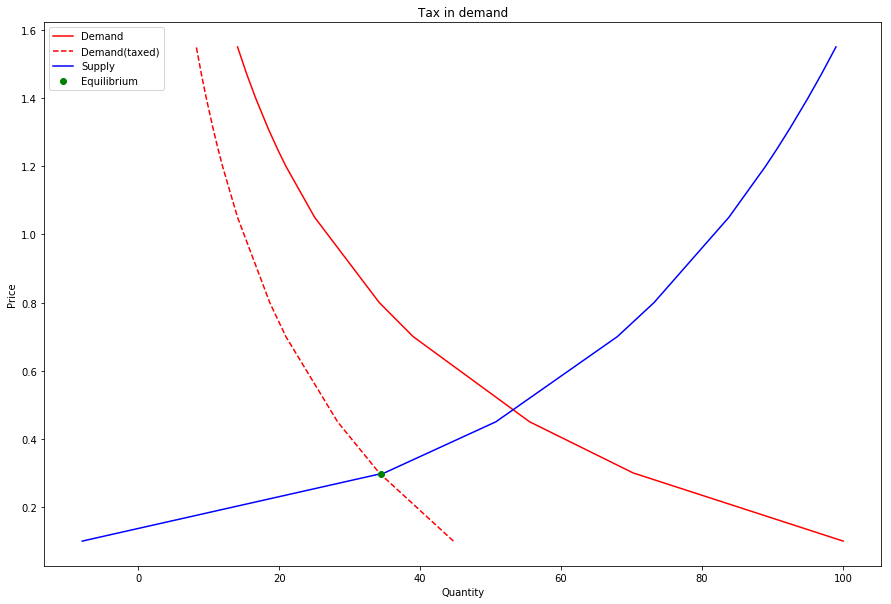

'Equilibrium is (34.40, 0.30)'

In [12]:
def taxed_d_f(x): return d_f(x + 0.5, *d_c)
def diff(x): return abs(taxed_d_f(x) - s_f(x, *s_c))

e_p = minimize(diff, 1, bounds=[bounds]).x[0]
e_q = s_f(e_p, *s_c)
plot(d_f(P, *d_c), P, 'r-', taxed_d_f(P), P, 'r--', s_f(P, *s_c), P, 'b-', e_q, e_p, 'go',
    legend=['Demand', 'Demand(taxed)', 'Supply', 'Equilibrium'], title='Tax in demand')
'Equilibrium is ({0:.2f}, {1:.2f})'.format(e_q, e_p)